**Creating a csv file which has the path of images and its name**

In [21]:
import os
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd

In [22]:
import shutil
import os

cache_path = os.path.expanduser(r"C:\Users\SAHIL\AppData\Local\Temp\tfhub_modules")
shutil.rmtree(cache_path)
print("✅ Cache cleared.")

✅ Cache cleared.


In [23]:
# Load MoveNet Thunder Model
model_url = "https://tfhub.dev/google/movenet/singlepose/thunder/4"
movenet = hub.load(model_url)


In [24]:
# Function to extract keypoints from an image
def extract_keypoints(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img, axis=0).astype(np.int32)

    outputs = movenet.signatures["serving_default"](input=img)
    keypoints = outputs['output_0'].numpy().reshape(-1, 3)[:, :2]  # Extract (x, y)

    return keypoints.flatten()

# Directory where images are stored (organized by pose names)
images_dir = "images"

data, labels = [], []
for pose in os.listdir(images_dir):
    pose_path = os.path.join(images_dir, pose)
    if os.path.isdir(pose_path):
        for img_file in os.listdir(pose_path):
            img_path = os.path.join(pose_path, img_file)
            keypoints = extract_keypoints(img_path)
            data.append(keypoints)
            labels.append(pose)  # Use folder name as label

# Save dataset to CSV
df = pd.DataFrame(data)
df["label"] = labels
df.to_csv("yoga_keypoints.csv", index=False)
print("✅ Dataset Created: yoga_keypoints.csv")

✅ Dataset Created: yoga_keypoints.csv


In [25]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import json

In [26]:

# Load dataset
df = pd.read_csv("yoga_keypoints.csv")
X, y = df.iloc[:, :-1].values, df["label"].values

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
model = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", RandomForestClassifier(n_estimators=200, random_state=42))
])
model.fit(X_train, y_train)

# Save trained model
joblib.dump(model, "yoga_pose_model.pkl")
print(f"✅ Model trained with {model.score(X_test, y_test) * 100:.2f}% accuracy.")
print("✅ Model saved as yoga_pose_model.pkl")


✅ Model trained with 98.21% accuracy.
✅ Model saved as yoga_pose_model.pkl


In [7]:
from sklearn.metrics import accuracy_score

# Predict on test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 98.95%


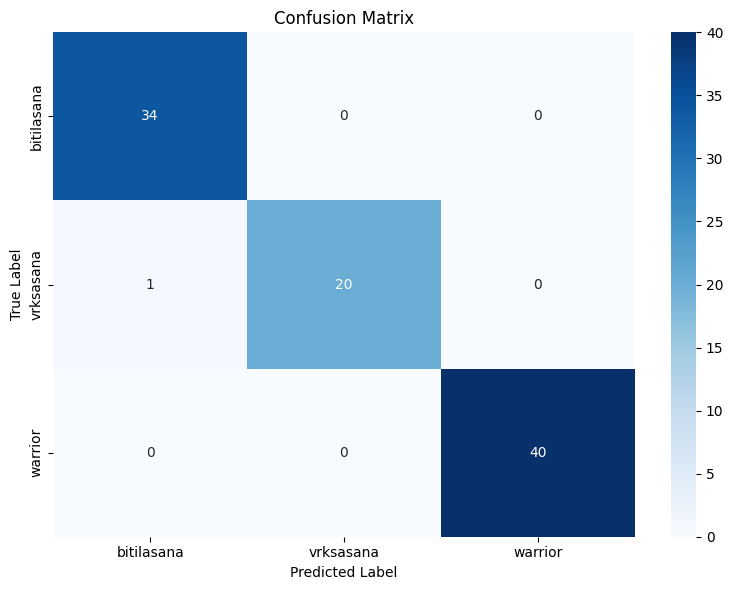

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()


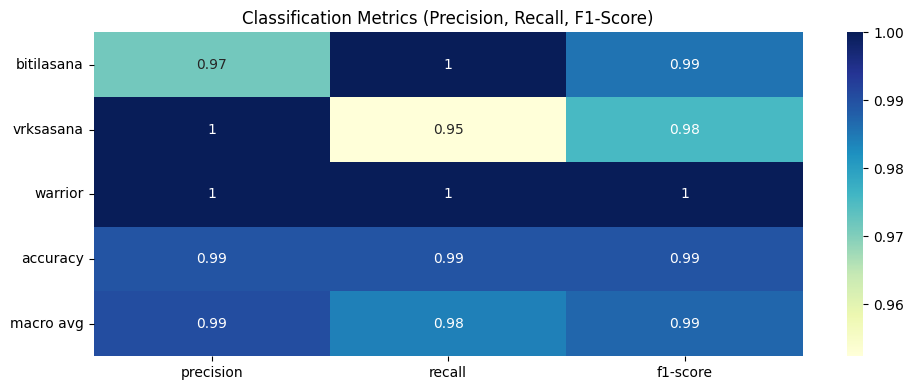

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

# Convert classification report to dataframe
report_dict = classification_report(y_test, y_pred, target_names=model.classes_, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()

# Plot
plt.figure(figsize=(10, 4))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap='YlGnBu')
plt.title("Classification Metrics (Precision, Recall, F1-Score)")
plt.tight_layout()
plt.savefig("classification_report.png")
plt.show()


In [6]:
import cv2
import numpy as np
import joblib
import tensorflow_hub as hub
import pandas as pd
from scipy.spatial import distance
import time


In [7]:

# Load MoveNet Thunder Model
model_url = "https://tfhub.dev/google/movenet/singlepose/thunder/4"
movenet = hub.load(model_url)

# Load trained model & dataset
classifier = joblib.load("yoga_pose_model.pkl")
df = pd.read_csv("yoga_keypoints.csv")
ideal_keypoints = df.groupby("label").mean().to_dict(orient="index")

# Keypoint labels for reference
KEYPOINT_LABELS = [
    "Nose", "Left Eye", "Right Eye", "Left Ear", "Right Ear", 
    "Left Shoulder", "Right Shoulder", "Left Elbow", "Right Elbow", 
    "Left Wrist", "Right Wrist", "Left Hip", "Right Hip",
    "Left Knee", "Right Knee", "Left Ankle", "Right Ankle"
]

# Function to extract keypoints from a frame
def extract_keypoints_from_frame(frame):
    img = cv2.resize(frame, (256, 256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img, axis=0).astype(np.int32)

    outputs = movenet.signatures["serving_default"](input=img)
    keypoints = outputs["output_0"].numpy().reshape(-1, 3)

    # Keep only (x, y) coordinates, ignore confidence scores
    keypoints = keypoints[:, :2]

    return keypoints.flatten(), keypoints  # Flattened & full keypoints

# Enhanced function to check if enough keypoints are detected
def is_valid_pose(keypoints_array):
    # Check that we have at least 15 keypoints detected (out of 17)
    visible_joints = np.count_nonzero(keypoints_array[:, 0])
    if visible_joints < 15:
        return False
    
    # Define critical joints that must be visible
    critical_joints = {
        'shoulders': [5, 6],  # Left and right shoulder
        'hips': [11, 12],     # Left and right hip
        'knees': [13, 14],    # Left and right knee
        'ankles': [15, 16]    # Left and right ankle
    }
    
    # Check all critical joints are detected
    for joint_type, indices in critical_joints.items():
        if not all(keypoints_array[i, 0] > 0 for i in indices):
            return False
    
    # Additional check: ensure body proportions are reasonable
    # Calculate distance between shoulders
    shoulder_width = distance.euclidean(keypoints_array[5][:2], keypoints_array[6][:2])
    # Calculate distance from shoulder to hip
    torso_height = distance.euclidean(keypoints_array[5][:2], keypoints_array[11][:2])
    
    # If proportions are unrealistic (too wide or too narrow)
    if shoulder_width < 0.1 or shoulder_width > 0.5 or torso_height < 0.1:
        return False
    
    return True

# Function to calculate corrections & rating
def calculate_corrections(detected_keypoints, ideal_pose_keypoints_dict):
    corrections = []
    total_diff = 0
    num_compared = 0

    # Convert ideal keypoints to numpy array
    ideal_pose_keypoints = np.zeros(len(KEYPOINT_LABELS)*2)
    for i in range(len(KEYPOINT_LABELS)):
        ideal_pose_keypoints[i*2] = ideal_pose_keypoints_dict[f"{i*2}"]
        ideal_pose_keypoints[i*2+1] = ideal_pose_keypoints_dict[f"{i*2+1}"]

    for i, label in enumerate(KEYPOINT_LABELS):
        detected = detected_keypoints[i*2:i*2+2]
        ideal = ideal_pose_keypoints[i*2:i*2+2]

        if np.all(detected > 0) and np.all(ideal > 0):  # Only compare if both are detected
            diff = distance.euclidean(detected, ideal)
            total_diff += diff
            num_compared += 1
            if diff > 0.15:  # Adjusted threshold for normalized coordinates
                direction = ""
                if detected[0] - ideal[0] > 0.05:
                    direction += "move left "
                elif detected[0] - ideal[0] < -0.05:
                    direction += "move right "
                
                if detected[1] - ideal[1] > 0.05:
                    direction += "move up "
                elif detected[1] - ideal[1] < -0.05:
                    direction += "move down "
                
                if direction:
                    corrections.append(f"Adjust {label}: {direction.strip()}")

    if num_compared > 0:
        avg_diff = total_diff / num_compared
        rating = max(10 - int(avg_diff / 0.05), 1)  # Adjusted rating calculation
    else:
        rating = 1

    return corrections, rating

# Main execution

def main():
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print(json.dumps({
            "status": "failure",
            "pose": None,
            "confidence": None,
            "rating": None,
            "feedback": None,
            "corrections": [],
            "errors": ["Could not open webcam."]
        }, indent=2))
        return

    start_time = time.time()
    frames = []
    valid_frames = 0

    while time.time() - start_time < 15:
        ret, frame = cap.read()
        if not ret:
            break

        keypoints_flat, keypoints_array = extract_keypoints_from_frame(frame)
        if is_valid_pose(keypoints_array):
            frames.append((keypoints_flat, keypoints_array))
            valid_frames += 1

        cv2.putText(frame, "Hold your yoga pose for 15 seconds", (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(frame, f"Time remaining: {int(15 - (time.time() - start_time))}s", 
                    (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.imshow("Yoga Pose Detection", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    if valid_frames < 5:
        result = {
            "status": "failure",
            "pose": None,
            "confidence": None,
            "rating": None,
            "feedback": None,
            "corrections": [],
            "errors": [
                "Could not detect a valid yoga pose.",
                "Make sure your full body is visible.",
                "Improve lighting or camera position.",
            ]
        }
    else:
        best_frame = max(frames, key=lambda x: np.count_nonzero(x[1][:, 0]))
        keypoints_flat, keypoints_array = best_frame
        keypoints_flat = keypoints_flat.reshape(1, -1)

        pose_probabilities = classifier.predict_proba(keypoints_flat)
        predicted_pose = classifier.predict(keypoints_flat)[0]
        max_confidence = float(np.max(pose_probabilities))

        if max_confidence < 0.85 or predicted_pose not in ideal_keypoints:
            result = {
                "status": "failure",
                "pose": predicted_pose,
                "confidence": max_confidence,
                "rating": None,
                "feedback": None,
                "corrections": [],
                "errors": ["Pose detected with low confidence."]
            }
        else:
            corrections, rating = calculate_corrections(keypoints_flat.flatten(), ideal_keypoints[predicted_pose])

            if rating >= 8:
                feedback = "Excellent form! Keep it up! 💪"
            elif rating >= 5:
                feedback = "Good attempt! Some minor adjustments needed."
            else:
                feedback = "Needs work. Focus on the corrections below."

            result = {
                "status": "success",
                "pose": predicted_pose,
                "confidence": max_confidence,
                "rating": rating,
                "feedback": feedback,
                "corrections": corrections if corrections else ["No major corrections needed! Perfect pose! 🎉"],
                "errors": []
            }

    print(json.dumps(result, indent=2))

if __name__ == "__main__":
    main()


{
  "status": "failure",
  "pose": "warrior",
  "confidence": 0.465,
  "rating": null,
  "feedback": null,
  "corrections": [],
  "errors": [
    "Pose detected with low confidence."
  ]
}


In [16]:
import cv2
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance

# ✅ Load model and data
movenet = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
classifier = joblib.load("yoga_pose_model.pkl")
df = pd.read_csv("yoga_keypoints.csv")
ideal_keypoints = df.groupby("label").mean().to_dict(orient="index")

KEYPOINT_LABELS = [
    "Nose", "Left Eye", "Right Eye", "Left Ear", "Right Ear", 
    "Left Shoulder", "Right Shoulder", "Left Elbow", "Right Elbow", 
    "Left Wrist", "Right Wrist", "Left Hip", "Right Hip",
    "Left Knee", "Right Knee", "Left Ankle", "Right Ankle"
]

# ✅ Extract keypoints from image
def extract_keypoints_from_image(image_path):
    image = cv2.imread(image_path)
    original = image.copy()
    h_orig, w_orig, _ = original.shape

    img = cv2.resize(image, (256, 256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img, axis=0).astype(np.int32)

    outputs = movenet.signatures['serving_default'](input=img)
    keypoints = outputs['output_0'].numpy().reshape(-1, 3)[:, :2]  # x, y

    return keypoints, original, w_orig, h_orig

# ✅ Correction logic
def calculate_corrections(detected_keypoints, ideal_pose_keypoints_dict):
    corrections = []
    total_diff = 0
    num_compared = 0
    detailed_corrections = []

    ideal_pose_keypoints = np.zeros(len(KEYPOINT_LABELS) * 2)
    for i in range(len(KEYPOINT_LABELS)):
        ideal_pose_keypoints[i*2] = ideal_pose_keypoints_dict.get(f"{i*2}", 0)
        ideal_pose_keypoints[i*2+1] = ideal_pose_keypoints_dict.get(f"{i*2+1}", 0)

    for i, label in enumerate(KEYPOINT_LABELS):
        detected = detected_keypoints[i*2:i*2+2]
        ideal = ideal_pose_keypoints[i*2:i*2+2]

        if np.all(detected > 0) and np.all(ideal > 0):
            diff = distance.euclidean(detected, ideal)
            total_diff += diff
            num_compared += 1
            
            if diff > 0.15:
                direction = []
                if detected[0] - ideal[0] > 0.05:
                    direction.append("left")
                elif detected[0] - ideal[0] < -0.05:
                    direction.append("right")
                if detected[1] - ideal[1] > 0.05:
                    direction.append("up")
                elif detected[1] - ideal[1] < -0.05:
                    direction.append("down")

                detailed_corrections.append({
                    "body_part": label,
                    "direction": " and ".join(direction),
                    "distance": diff
                })

    rating = max(10 - int((total_diff / num_compared) / 0.05), 1) if num_compared > 0 else 1
    return detailed_corrections, rating

# ✅ Feedback
def get_feedback_message(rating):
    if rating >= 9:
        return "Excellent form! Your pose is nearly perfect! 💪"
    elif rating >= 7:
        return "Good form! Just a few minor adjustments needed."
    elif rating >= 5:
        return "Decent attempt! Focus on the corrections to improve your form."
    else:
        return "Needs improvement. Follow the correction tips carefully."

# ✅ Visualize corrections
def plot_keypoints(detected_kp, ideal_kp, corrections, width, height):
    CONNECTIONS = [
        (0, 1), (0, 2), (1, 3), (2, 4),
        (5, 6), (5, 7), (6, 8), (7, 9), (8, 10),
        (5, 11), (6, 12), (11, 12),
        (11, 13), (12, 14), (13, 15), (14, 16)
    ]

    plt.figure(figsize=(10, 8))
    plt.xlim(0, width)
    plt.ylim(height, 0)
    plt.gca().set_facecolor('white')

    # Plot skeleton connections
    for connection in CONNECTIONS:
        start, end = connection
        x_d_start, y_d_start = detected_kp[start]
        x_d_end, y_d_end = detected_kp[end]
        x_i_start, y_i_start = ideal_kp[start]
        x_i_end, y_i_end = ideal_kp[end]

        plt.plot([x_d_start, x_d_end], [y_d_start, y_d_end], 'r-', linewidth=2, label='Detected' if connection == CONNECTIONS[0] else "")
        plt.plot([x_i_start, x_i_end], [y_i_start, y_i_end], 'g-', linewidth=2, label='Ideal' if connection == CONNECTIONS[0] else "")

    # Plot keypoints
    for i, label in enumerate(KEYPOINT_LABELS):
        x_d, y_d = detected_kp[i]
        x_i, y_i = ideal_kp[i]
        plt.plot(x_d, y_d, 'ro', markersize=6)
        plt.plot(x_i, y_i, 'go', markersize=6)
        plt.text(x_d + 5, y_d, label, color='red', fontsize=8)

        # Draw correction arrow if applicable
        if any(c['body_part'] == label for c in corrections):
            plt.arrow(x_d, y_d, x_i - x_d, y_i - y_d, head_width=5, color='blue')

    plt.title("Red: Detected | Green: Ideal | Blue: Correction Arrows")
    plt.legend()
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# ✅ Visualize distance heatmap
def plot_distance_heatmap(corrections):
    if not corrections:
        print("No corrections needed.")
        return
    parts = [c['body_part'] for c in corrections]
    distances = [c['distance'] for c in corrections]

    plt.figure(figsize=(8, 4))
    sns.barplot(x=parts, y=distances, palette="coolwarm")
    plt.xticks(rotation=45)
    plt.ylabel("Correction Distance")
    plt.title("Distance of Body Parts Needing Correction")
    plt.tight_layout()
    plt.show()

# ✅ Evaluate a single image
def evaluate_image(image_path):
    print(f"\n🖼️ Evaluating: {image_path}")
    keypoints, original_image, w, h = extract_keypoints_from_image(image_path)
    keypoints_flat = keypoints.flatten().reshape(1, -1)

    predicted_pose = classifier.predict(keypoints_flat)[0]
    print(f"🔍 Predicted Pose: {predicted_pose}")

    # Corrections use normalized keypoints
    corrections, rating = calculate_corrections(keypoints_flat[0], ideal_keypoints[predicted_pose])
    feedback = get_feedback_message(rating)

    print(f"⭐ Rating: {rating}/10")
    print(f"📢 Feedback: {feedback}")
    if corrections:
        print("🔧 Corrections needed:")
        for c in corrections:
            print(f" - {c['body_part']}: move {c['direction']} ({c['distance']:.2f} units)")
    else:
        print("✅ No corrections needed!")

    # Scale keypoints for plotting
    detected_kp_scaled = keypoints * [w, h]
    ideal_kp = np.array([ideal_keypoints[predicted_pose].get(str(i), 0) for i in range(34)]).reshape(-1, 2)
    ideal_kp_scaled = ideal_kp * [w, h]
    # ideal_kp_scaled = ideal_kp_scaled.reshape(-1, 2)  # ✅ Important fix

    # Visuals
    plot_keypoints(detected_kp_scaled, ideal_kp_scaled, corrections, w, h)
    plot_distance_heatmap(corrections)



🖼️ Evaluating: Vrksasana-correct.jpeg
🔍 Predicted Pose: vrksasana
⭐ Rating: 9/10
📢 Feedback: Excellent form! Your pose is nearly perfect! 💪
✅ No corrections needed!


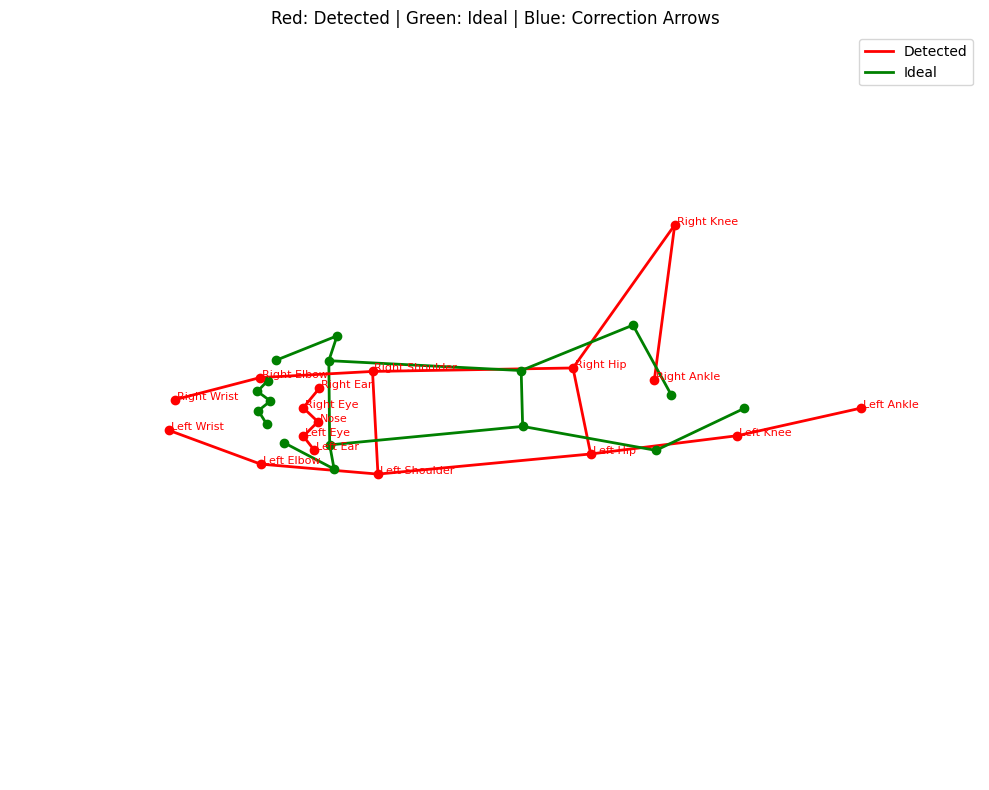

No corrections needed.


In [17]:
# ✅ Path to a CORRECT yoga image
evaluate_image("Vrksasana-correct.jpeg")



🖼️ Evaluating: vrksana-incorrect-3.jpeg
🔍 Predicted Pose: vrksasana
⭐ Rating: 7/10
📢 Feedback: Good form! Just a few minor adjustments needed.
🔧 Corrections needed:
 - Left Elbow: move right and up (0.26 units)
 - Right Elbow: move right and up (0.21 units)
 - Left Wrist: move right and up (0.40 units)
 - Right Wrist: move right (0.26 units)


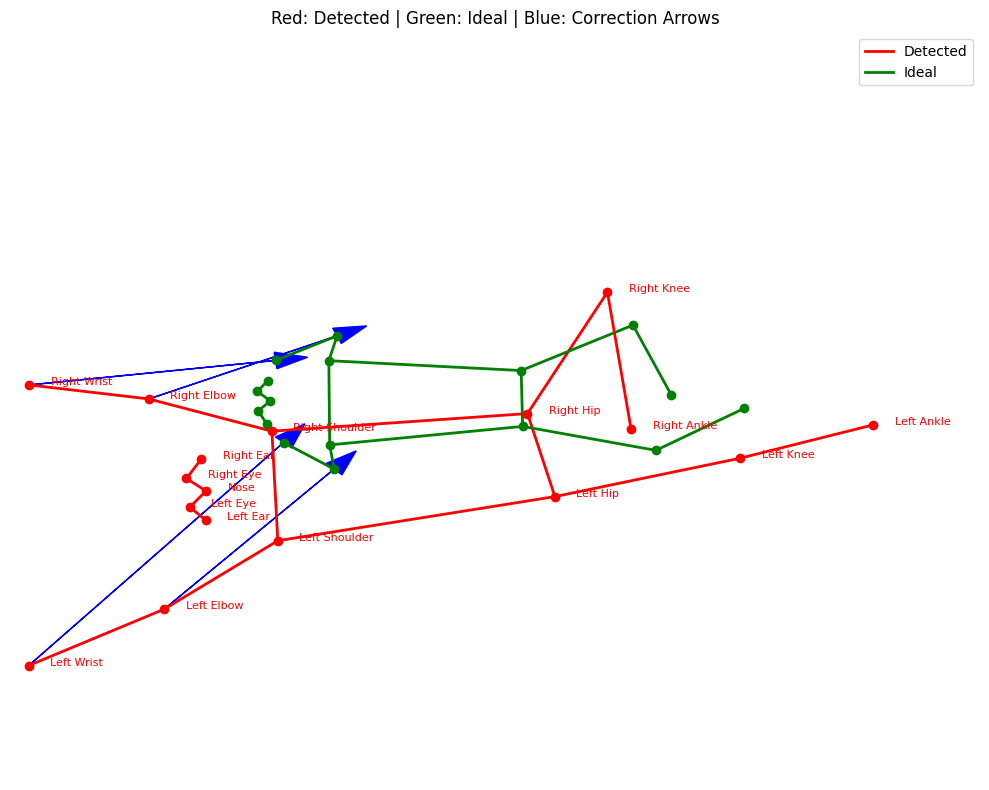

C:\Users\SAHIL\AppData\Local\Temp\ipykernel_5312\590231778.py:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=parts, y=distances, palette="coolwarm")


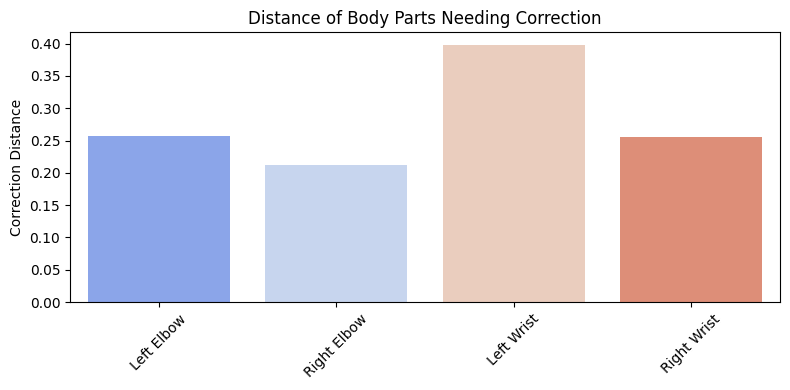

In [18]:
evaluate_image("vrksana-incorrect-3.jpeg")

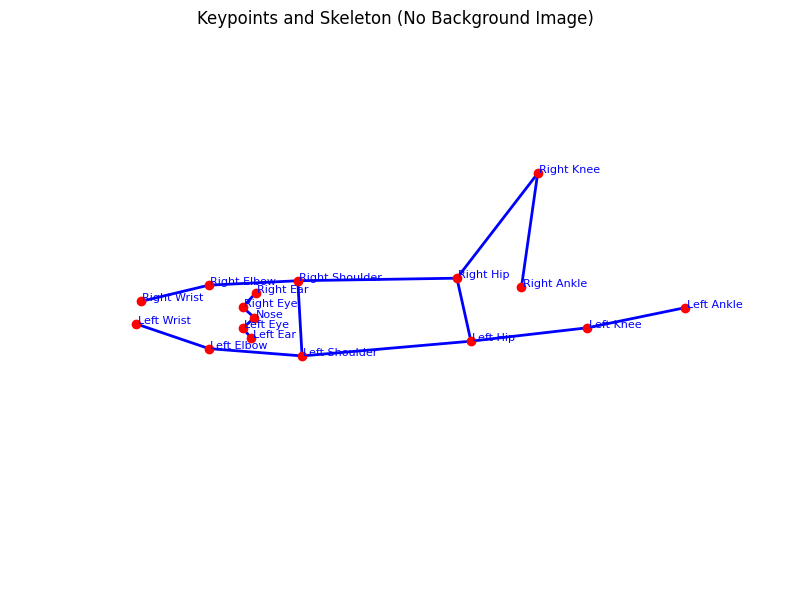

In [7]:
import cv2
import numpy as np
import tensorflow_hub as hub
import matplotlib.pyplot as plt

# Load MoveNet model
movenet = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")

# Keypoint labels
KEYPOINT_LABELS = [
    "Nose", "Left Eye", "Right Eye", "Left Ear", "Right Ear", 
    "Left Shoulder", "Right Shoulder", "Left Elbow", "Right Elbow", 
    "Left Wrist", "Right Wrist", "Left Hip", "Right Hip",
    "Left Knee", "Right Knee", "Left Ankle", "Right Ankle"
]

# Skeleton connections
CONNECTIONS = [
    (0, 1), (0, 2), (1, 3), (2, 4),  # Head
    (5, 6), (5, 7), (6, 8),          # Shoulders to elbows
    (7, 9), (8, 10),                  # Elbows to wrists
    (5, 11), (6, 12), (11, 12),      # Torso
    (11, 13), (12, 14),               # Hips to knees
    (13, 15), (14, 16)                # Knees to ankles
]

def extract_and_plot_corrected_keypoints(image_path):
    image = cv2.imread(image_path)
    original = image.copy()
    h, w, _ = original.shape

    # Resize and prepare input
    img_resized = cv2.resize(original, (256, 256))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    input_tensor = np.expand_dims(img_rgb, axis=0).astype(np.int32)

    # Get keypoints from MoveNet
    outputs = movenet.signatures['serving_default'](input=input_tensor)
    keypoints_with_conf = outputs['output_0'].numpy().reshape(-1, 3)
    keypoints = keypoints_with_conf[:, :2]  # Get just x,y coordinates

    # Scale keypoints to original image size
    keypoints[:, 0] *= w
    keypoints[:, 1] *= h

    # Create blank white background
    plt.figure(figsize=(8, 6))
    plt.xlim(0, w)
    plt.ylim(h, 0)  # Invert y-axis to match image coordinates
    plt.gca().set_facecolor('white')

    # Draw skeleton connections
    for connection in CONNECTIONS:
        start_idx, end_idx = connection
        start_point = keypoints[start_idx]
        end_point = keypoints[end_idx]
        plt.plot([start_point[0], end_point[0]], 
                [start_point[1], end_point[1]], 
                'b-', linewidth=2)

    # Draw keypoints
    for i, (x, y) in enumerate(keypoints):
        plt.plot(x, y, 'ro', markersize=6)
        plt.text(x + 4, y, KEYPOINT_LABELS[i], fontsize=8, color='blue')

    plt.title("Keypoints and Skeleton (No Background Image)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Example usage
extract_and_plot_corrected_keypoints("Vrksasana-correct.jpeg")


🖼️ Evaluating: correct-warrioir.jpg
🔍 Predicted Pose: warrior
⭐ Rating: 9/10
📢 Feedback: Excellent form! Your pose is nearly perfect! 💪
🔧 Corrections needed:
 - Left Ankle: move left and up (0.20 units)


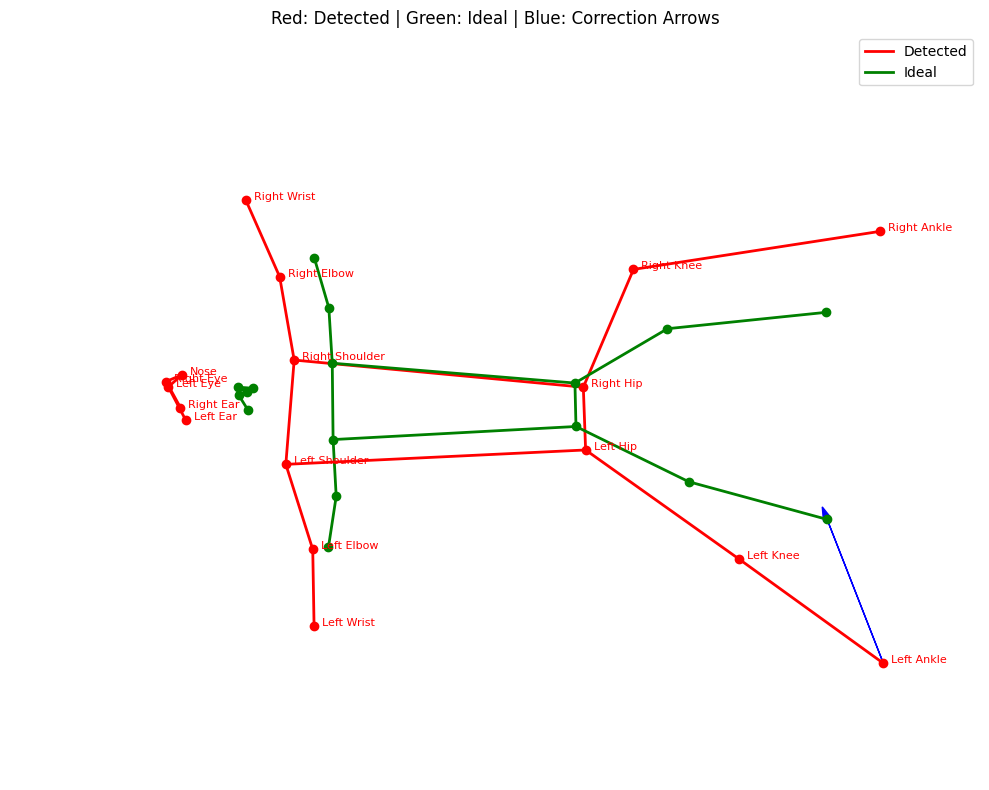

C:\Users\SAHIL\AppData\Local\Temp\ipykernel_5312\590231778.py:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=parts, y=distances, palette="coolwarm")


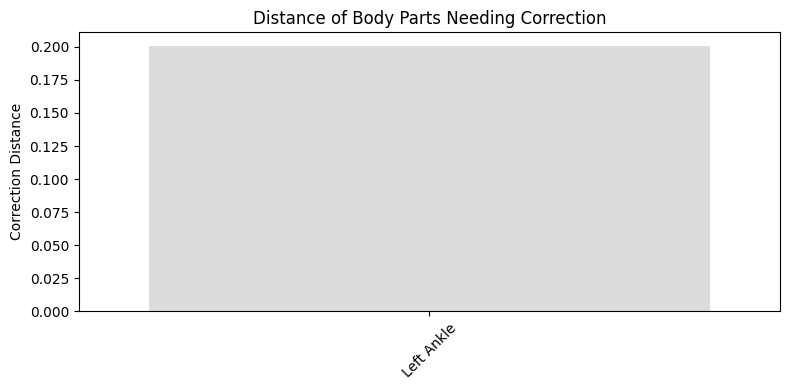

In [19]:
evaluate_image("correct-warrioir.jpg")


🖼️ Evaluating: warrioir-incorrect.png
🔍 Predicted Pose: warrior
⭐ Rating: 6/10
📢 Feedback: Decent attempt! Focus on the corrections to improve your form.
🔧 Corrections needed:
 - Nose: move up (0.19 units)
 - Left Eye: move up (0.21 units)
 - Right Eye: move up (0.21 units)
 - Left Ear: move up (0.19 units)
 - Right Ear: move up (0.20 units)
 - Left Elbow: move left and up (0.24 units)
 - Right Elbow: move right and up (0.36 units)
 - Left Wrist: move left and up (0.37 units)
 - Right Wrist: move right and up (0.50 units)
 - Right Knee: move right and down (0.24 units)
 - Left Ankle: move up (0.21 units)
 - Right Ankle: move down (0.21 units)


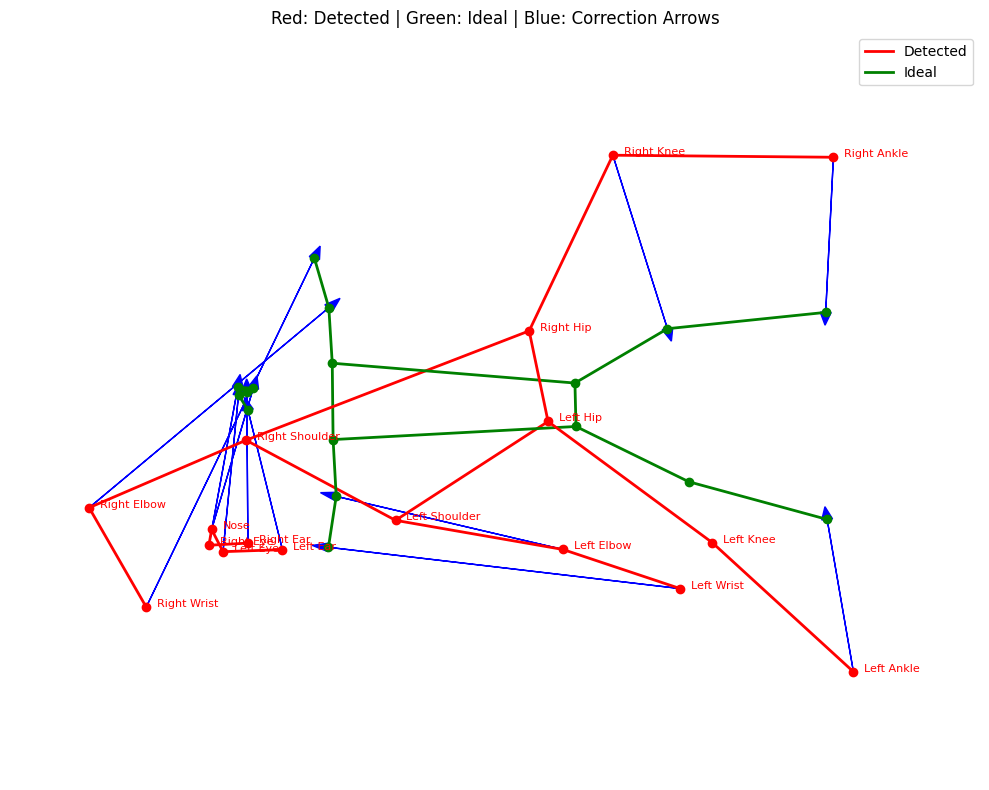

C:\Users\SAHIL\AppData\Local\Temp\ipykernel_5312\590231778.py:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=parts, y=distances, palette="coolwarm")


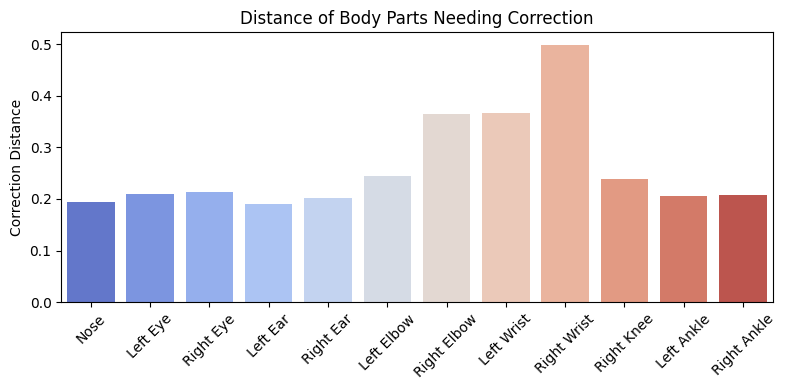

In [20]:
evaluate_image("warrioir-incorrect.png")